In [1]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
from base_rl.models import ACSequential, ActorCritic, EquivariantActorCritic
from base_rl.higher_order import make_train, CONFIG
from symmetrizer.symmetrizer import  C2PermGroup, ac_symmmetrizer_factory
from dyna.ac_higher_order import DynaHyperParams, ActorCriticHyperParams
import matplotlib
matplotlib.rcParams.update( {"text.usetex": True, "font.family": "serif",})

In [2]:
num_seeds = 128
key = jax.random.PRNGKey(42)
sym_key, key = jax.random.split(key)

keys = jax.random.split(key, num_seeds)

def SymmetrizerNet(action_dim: int) -> ACSequential:
    layer_list = [
        4,
        64,
        64,
    ]
    return ac_symmmetrizer_factory(
        sym_key,
        C2PermGroup(),
        layer_list + [action_dim],
        [True] * (len(layer_list) + 1),
    )
CONFIG["ANNEAL_LR"] = False
for net_init in [
    ActorCritic,
    EquivariantActorCritic,
    SymmetrizerNet,
]:
    print(net_init.__name__)
    jit_train = jax.vmap(jax.jit(make_train(CONFIG, net_init)))
    results = jit_train(keys)
    episodic_returns = results["metrics"][0]["returned_episode_returns"].reshape(
        (num_seeds, -1)
    )
    jnp.save(f"{net_init.__name__}.npy", episodic_returns)
    del jit_train

2023-08-30 10:21:23.811638: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 25435242496
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


ActorCritic
128
976.0


Name: ActorCritic
Param Size: 9155
Baseline
107.0 +- 6.007217966590349
258.78906 +- 11.092487446171203
486.32812 +- 6.294949443752401
Name: SymmetrizerNet
Param Size: 9155
Symmetrizer
108.61719 +- 5.952603068765568
241.96094 +- 10.163914823274947
482.60938 +- 7.02394156608411
Name: EquivariantActorCritic
Param Size: 8961
G-CNN
157.5625 +- 7.707255945524075
346.60938 +- 11.550730236717657
488.1797 +- 5.560759434887541


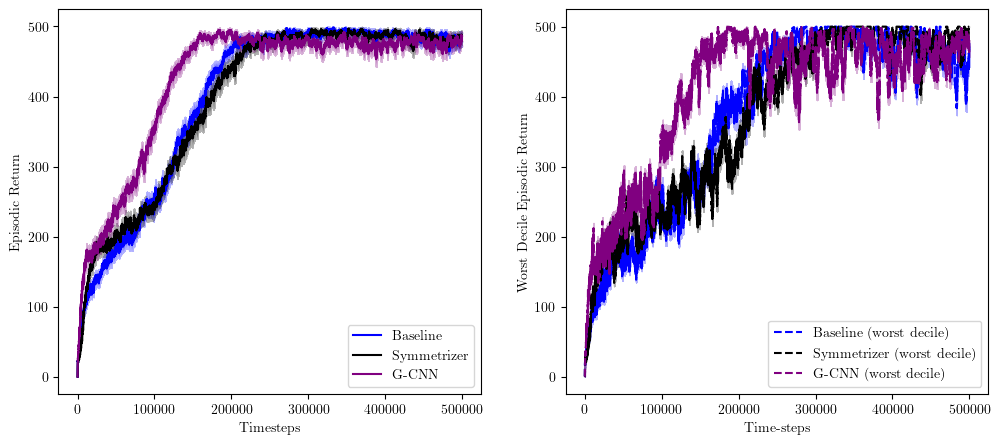

In [ ]:
names= [ "Baseline", "Symmetrizer", "G-CNN"]
def moving_average(x, w=10):
    return np.convolve(x, np.ones(w), "valid") / w


fig, ax = plt.subplots(1, 2, figsize=(12, 5))
colors = ["blue", "black", "purple", "red", "green"]
for c, init_fn, name  in zip(
    colors,
    [
        ActorCritic,
        SymmetrizerNet,
        EquivariantActorCritic,
    ],
    names
):
    model = init_fn(2)
    if init_fn in [SymmetrizerNet]:
        params = model.init(jax.random.PRNGKey(0), jnp.zeros((1, 4)))
    else:
        params = model.init(jax.random.PRNGKey(0), jnp.zeros((4)))
    print("Name:", init_fn.__name__)
    # print("Param Count:", jax.tree_util.tree_map(lambda x: x.shape, params))
    print("Param Size:", sum(x.size for x in jax.tree_util.tree_leaves(params)))
    episodic_returns = np.load(f"{init_fn.__name__}.npy")
    returns_std = moving_average(episodic_returns.std(axis=0)) / np.sqrt(num_seeds)
    returns_mean = moving_average(episodic_returns.mean(axis=0))
    returns_upper = returns_mean + returns_std
    returns_lower = returns_mean - returns_std
    x = np.arange(len(returns_mean))
    
    print(name)
    print(episodic_returns.mean(axis=0)[10_000],"+-", episodic_returns.std(axis=0)[10_000]/np.sqrt(num_seeds))
    print(episodic_returns.mean(axis=0)[100_000],"+-", episodic_returns.std(axis=0)[100_000]/np.sqrt(num_seeds))
    print(episodic_returns.mean(axis=0)[-1],"+-", episodic_returns.std(axis=0)[-1]/np.sqrt(num_seeds))

    ax[0].plot(x, returns_mean, label=f"{name}", color=c)
    ax[0].fill_between(x, returns_lower, returns_upper, alpha=0.3, color=c)
    ax[0].set_xlabel("Timesteps")
    ax[0].set_ylabel("Episodic Return")

    cumulative_returns = np.cumsum(episodic_returns, axis=1)[:, -1]
    worst_decile = np.quantile(cumulative_returns, 0.1)
    worst_mean = episodic_returns[cumulative_returns < worst_decile].mean(axis=0)
    worst_std = episodic_returns[cumulative_returns < worst_decile].std(
        axis=0
    ) / np.sqrt(128)
    worst_upper = worst_mean + worst_std
    worst_lower = worst_mean - worst_std
    ax[1].plot(
        x,
        moving_average(worst_mean),
        label=f"{name} (worst decile)",
        linestyle="--",
        color=c,
    )
    ax[1].fill_between(
        x,
        moving_average(worst_lower),
        moving_average(worst_upper),
        alpha=0.3,
        color=c,
    )
    ax[1].set_xlabel("Time-steps")
    ax[1].set_ylabel("Worst Decile Episodic Return")

ax[0].legend()
ax[1].legend()
plt.show()
fig.savefig("../msc_thesis/Figures/cart_pole_returns.png", dpi=300)